# scikit-learnのトレーニング♨

## 性能の評価、チューニング 編

## [目次](TableOfContents.ipynb)
- [環境準備](#環境準備)
  - [インポート](#インポート)
  - [プロキシ設定](#プロキシ設定)
  - [共通関数定義](#共通関数定義)
- [性能の評価](#性能の評価)
  - [回帰問題](#回帰問題)
  - [分類問題](#分類問題)
- [汎化性能の評価](#汎化性能の評価)
  - [k分割交差検証法](#k分割交差検証法)
  - [層化k分割交差検証法](#層化k分割交差検証法)
- [チューニング](#チューニング)
  - [グリッドサーチ](#グリッドサーチ)
  - [特徴量の選択とエンジニアリング](#特徴量の選択とエンジニアリング)

## 参考
開発基盤部会 Wiki
- データマイニング（DM）- Python  
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20Python#y4054d35

## [環境準備](ScikitLearnTraining0.ipynb)

### インポート

In [1]:
import io
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets                                 # サンプル・データセット
from sklearn.datasets import make_regression                 # 回帰データセット作成
from sklearn.datasets import make_blobs                      # 分類データセット作成
from sklearn.preprocessing import StandardScaler             # 標準化
from sklearn.model_selection import train_test_split         # データ分割

from sklearn.linear_model import LinearRegression            # 線形回帰
from sklearn.preprocessing import PolynomialFeatures         # 多項式回帰の変数変換
from sklearn.linear_model import Ridge                       # 多項式回帰のRidge回帰
from sklearn.linear_model import Lasso                       # 多項式回帰のLASSO回帰
from sklearn.linear_model import ElasticNet                  # 多項式回帰のLASSO回帰
from sklearn.linear_model import Perceptron                  # 単純パーセプトロン線形分類器
from sklearn.linear_model import LogisticRegression          # ロジスティク回帰
from sklearn.svm import SVC                                  # サポートベクターマシン（SVM）分類器
from sklearn.tree import DecisionTreeClassifier              # 決定木（分類木）
from sklearn.ensemble import RandomForestClassifier          # ランダムフォレスト（分類木）
from sklearn.ensemble import GradientBoostingClassifier      # 勾配ブースティング木（分類木）
from sklearn.decomposition import PCA                        # 主成分分析
from sklearn.cluster import KMeans                           # k-means法 クラスタ分析
from sklearn.feature_extraction.text import CountVectorizer  # 自然言語処理ベクトル化
from sklearn.feature_extraction.text import TfidfTransformer # 自然言語ベクトルのTF-IDF計算
from sklearn.decomposition import LatentDirichletAllocation  # 自然言語ベクトルからLDAトピック抽出

from sklearn import metrics                                  # モデル評価
from sklearn.metrics import mean_squared_error as mse        # 精度評価（mse）
from sklearn.metrics import confusion_matrix                 # 混同行列
from sklearn.metrics import silhouette_samples               # シルエット係数
from sklearn.model_selection import cross_val_score          # 交差検証法
from sklearn.model_selection import KFold                    # k分割交差検証法
from sklearn.model_selection import StratifiedKFold          # 層化交差検証法
from sklearn.model_selection import GridSearchCV             # グリッドサーチ

import seaborn as sns                                        # matplotlibラッパ
from mlxtend.plotting import plot_decision_regions           # 決定領域表示関数
from matplotlib import cm                                    # カラーマップ処理

from numpy import linalg as LA                               # 線形代数ライブラリ

In [2]:
import warnings
warnings.filterwarnings('ignore')

### プロキシ設定

In [3]:
import os
proxies = {
    "http": os.getenv("HTTP_PROXY"),
    "https": os.getenv("HTTPS_PROXY")
}

### 共通関数定義

#### [分類問題のメトリック](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)表示関数

##### ミクロ平均
- クラスごとのサンプル数の偏りを調整しない場合の平均の取り方
- 多数派のクラスを重視したいときはミクロ平均を使う。

##### マクロ平均
- サンプル数の偏りを調整する場合の平均の取り方
- 全体を均等に評価したいときはマクロ平均を使う。

In [4]:
def print_metrics(label, pred):
    print('accuracy: %.3f' % metrics.accuracy_score(label, pred)) # 正答率
    
    print('\nmicro') # ミクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='micro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='micro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='micro')) # f値
    
    print('\nmacro') # マクロ平均
    print('recall: %.3f' % metrics.recall_score(label, pred, average='macro')) # 再現率
    print('precision: %.3f' % metrics.precision_score(label, pred, average='macro')) # 適合率
    print('f1_score: %.3f' % metrics.f1_score(label, pred, average='macro')) # f値

#### 混同行列のグラフ化関数

In [5]:
def plot_cm(confmat, label):
    numOfCls = len(label)
    fig, ax = plt.subplots(figsize=(numOfCls, numOfCls))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
            
    # 軸目盛を打つ場所を決める
    ax.set_xticks(np.arange(len(label)))
    ax.set_yticks(np.arange(len(label)))
    # 軸目盛を設定
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)
    #plt.xticks(np.array(label)) # x軸の目盛りを指定
    #plt.yticks(np.array(label)) # y軸の目盛りを指定
    
    plt.xlabel('y_pred label')
    plt.ylabel('y label')
    plt.show()

## 性能の評価
https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972

## 回帰問題

### 誤差による評価指標＆関数
- 平均二乗誤差（MSE：Mean Squared Error）、誤差の標準偏差（RMSE : Root Mean Squared Error）
- 参考：[単回帰、重回帰分析](ScikitLearnTraining1.ipynb)、[多項式回帰、正則化回帰分析](ScikitLearnTraining2.ipynb)

### 残差プロット
参考：[単回帰、重回帰分析](ScikitLearnTraining1.ipynb)、[多項式回帰、正則化回帰分析](ScikitLearnTraining2.ipynb)

## 分類問題
[分類問題のデータとアルゴリズム](ScikitLearnTraining3.ipynb)を使用。

### データ

In [6]:
iris = datasets.load_iris()
df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([df_data, df_target], axis=1)

np_arr=np.array(df)

# 標準化
ss = StandardScaler()

#### 2値分類

In [7]:
# 説明変数・目的変数の選択・分割
## PetalLengthCm, PetalWidthCm列の選択
x2=np_arr[50:150, 2:4] 
## Species列の選択
y2=np.array(np_arr[50:150, 4:5],dtype=np.int64) # 要素の型をint64に変換

# 標準化
ss.fit(x2)
x2_std = ss.transform(x2)

# 学習・テストデータの分割
x2_train, x2_test, y2_train, y2_test = train_test_split(x2_std, y2, test_size=0.3, random_state=0)

print(x2.shape)

(100, 2)


#### 3値分類

In [8]:
# 説明変数・目的変数の選択・分割
## PetalLengthCm, PetalWidthCm列の選択
x3=np_arr[:, 2:4] 
## Species列の選択
y3=np.array(np_arr[:, 4:5],dtype=np.int64) # 要素の型をint64に変換

# 標準化
ss.fit(x3)
x3_std = ss.transform(x3)

# 学習・テストデータの分割
x3_train, x3_test, y3_train, y3_test = train_test_split(x3_std, y3, test_size=0.3, random_state=0)

print(x3.shape)

(150, 2)


### アルゴリズム

#### 単純パーセプトロン線形分類器

##### ２クラス分類

In [9]:
ppn2 = Perceptron(eta0=0.1) # 学習率 0.1
ppn2.fit(x2_train, np.reshape(y2_train,(-1)))

Perceptron(eta0=0.1)

##### ３クラス分類

In [10]:
ppn3 = Perceptron(eta0=0.1) # 学習率 0.1
ppn3.fit(x3_train, np.reshape(y3_train,(-1)))

Perceptron(eta0=0.1)

#### サポートベクターマシン分類器

##### ２クラス分類

In [11]:
svc2 = SVC(kernel='rbf', gamma=0.1, C=10)
svc2.fit(x2_train, np.reshape(y2_train,(-1))) 

SVC(C=10, gamma=0.1)

##### ３クラス分類

In [12]:
svc3 = SVC(kernel='rbf', gamma=0.1, C=10)
svc3.fit(x3_train, np.reshape(y3_train,(-1))) 

SVC(C=10, gamma=0.1)

#### 勾配ブースティング木

##### ２クラス分類

In [13]:
tree_gbc2 = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1)
tree_gbc2.fit(x2_train, np.reshape(y2_train,(-1)))

GradientBoostingClassifier(random_state=0)

##### ３クラス分類

In [14]:
tree_gbc3 = GradientBoostingClassifier(random_state=0, max_depth=3, learning_rate=0.1)
tree_gbc3.fit(x3_train, np.reshape(y3_train,(-1)))

GradientBoostingClassifier(random_state=0)

### 混同行列

※ [AIプロジェクトのマネジメント > 詳細 > 違い > 色々な難しさ > 混同行列](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?AI%E3%83%97%E3%83%AD%E3%82%B8%E3%82%A7%E3%82%AF%E3%83%88%E3%81%AE%E3%83%9E%E3%83%8D%E3%82%B8%E3%83%A1%E3%83%B3%E3%83%88#a6b82222)

#### 混同行列表示処理関数

#### 2クラス分類の場合

##### 混同行列表示

###### 単純パーセプトロン線形分類器

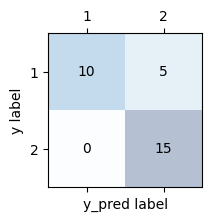

In [15]:
cm_ppn2 = confusion_matrix(y2_test, ppn2.predict(x2_test))
plot_cm(cm_ppn2, np.unique(y2_test))

###### サポートベクターマシン分類器

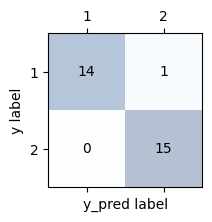

In [16]:
cm_svc2 = confusion_matrix(y2_test, svc2.predict(x2_test))
plot_cm(cm_svc2, np.unique(y2_test))

###### 勾配ブースティング木

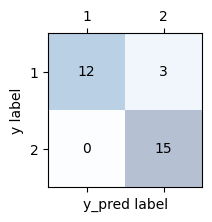

In [17]:
cm_tree2 = confusion_matrix(y2_test, tree_gbc2.predict(x2_test))
plot_cm(cm_tree2, np.unique(y2_test))

##### 混同行列による指標

※ [データマイニング（DM）- CRISP-DM > 詳細 > 評価 > 精度の評価](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)

###### 単純パーセプトロン線形分類器

In [18]:
print_metrics(y2_test, ppn2.predict(x2_test))

accuracy: 0.833

micro
recall: 0.833
precision: 0.833
f1_score: 0.833

macro
recall: 0.833
precision: 0.875
f1_score: 0.829


###### サポートベクターマシン分類器

In [19]:
print_metrics(y2_test, svc2.predict(x2_test))

accuracy: 0.967

micro
recall: 0.967
precision: 0.967
f1_score: 0.967

macro
recall: 0.967
precision: 0.969
f1_score: 0.967


###### 勾配ブースティング木

In [20]:
print_metrics(y2_test, tree_gbc2.predict(x2_test))

accuracy: 0.900

micro
recall: 0.900
precision: 0.900
f1_score: 0.900

macro
recall: 0.900
precision: 0.917
f1_score: 0.899


#### 3クラス分類の場合

##### 混同行列表示

###### 単純パーセプトロン線形分類器

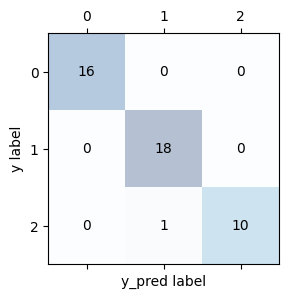

In [21]:
cm_ppn3 = confusion_matrix(y3_test, ppn3.predict(x3_test))
plot_cm(cm_ppn3, np.unique(y3_test))

###### サポートベクターマシン分類器

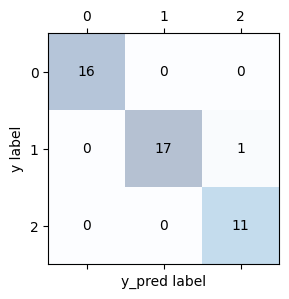

In [22]:
cm_svc3 = confusion_matrix(y3_test, svc3.predict(x3_test))
plot_cm(cm_svc3, np.unique(y3_test))

###### 勾配ブースティング木

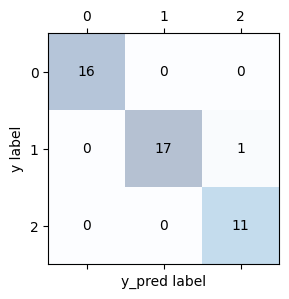

In [23]:
cm_tree3 = confusion_matrix(y3_test, tree_gbc3.predict(x3_test))
plot_cm(cm_tree3, np.unique(y3_test))

##### 混同行列による指標

※ [データマイニング（DM）- CRISP-DM > 詳細 > 評価 > 精度の評価](https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?%E3%83%87%E3%83%BC%E3%82%BF%E3%83%9E%E3%82%A4%E3%83%8B%E3%83%B3%E3%82%B0%EF%BC%88DM%EF%BC%89-%20CRISP-DM#uf759972)

###### 単純パーセプトロン線形分類器

In [24]:
print_metrics(y3_test, ppn3.predict(x3_test))

accuracy: 0.978

micro
recall: 0.978
precision: 0.978
f1_score: 0.978

macro
recall: 0.970
precision: 0.982
f1_score: 0.975


###### サポートベクターマシン分類器

In [25]:
print_metrics(y3_test, svc3.predict(x3_test))

accuracy: 0.978

micro
recall: 0.978
precision: 0.978
f1_score: 0.978

macro
recall: 0.981
precision: 0.972
f1_score: 0.976


###### 勾配ブースティング木

In [26]:
print_metrics(y3_test, tree_gbc3.predict(x3_test))

accuracy: 0.978

micro
recall: 0.978
precision: 0.978
f1_score: 0.978

macro
recall: 0.981
precision: 0.972
f1_score: 0.976


## 汎化性能の評価（交差検証）
汎化性能が上がるようにチューニングする際に有用（後述の[グリットサーチ](#グリットサーチ)と併用可能）
- 学習時にのみ使用し汎化性能の良いパラメタに決める。
- 標準偏差で評価するがアンサンブル的な推論をする訳ではない。
- 実際に推論するにはホールド・アウト法で学習し直す方が良い。

### k分割交差検証法
- [概要](https://www.google.com/search?q=k%E5%88%86%E5%89%B2%E4%BA%A4%E5%B7%AE%E6%A4%9C%E8%A8%BC%E6%B3%95&tbm=isch)の確認
- [回帰問題のデータとアルゴリズム](ScikitLearnTraining1.ipynb)を使用。

#### データ

In [27]:
url = 'https://dotnetdevelopmentinfrastructure.osscons.jp/index.php?plugin=attach&pcmd=open&file=Boston.csv&refer=FrontPage'
res = requests.get(url) # , verify=False, proxies=proxies) # プロキシ
df = pd.read_csv(io.BytesIO(res.content), encoding='utf-8', sep=",")
df=df.drop('Unnamed: 0',axis=1)
df = df.loc[:, ['lstat', 'rm', 'medv']]
x = np.array(df.loc[:, ['lstat', 'rm']])
y = np.array(df.loc[:, ['medv']])

#### アルゴリズム

##### アルゴリズムの初期化

In [28]:
lr = LinearRegression()

##### k分割交差検証法の設定
- n_splits:  
  - データを分割する通常5〜10個程度の個数。
  - 小さいデータほど数多く分割する必要がある｡
- shuffle:  
  - 分割を行う前にデータをシャッフルするかどうか。
  - Trueにしておいた方が信頼性が上がる。
- random_state:  
  - 乱数生成器の状態。
  - これを固定しておけば､毎回同じ分割結果が得られる。

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

#### 学習

In [30]:
scores = cross_val_score(lr, x, y, cv=kf)
scores

array([0.54090848, 0.70922084, 0.57458547, 0.55307476, 0.738459  ])

#### 評価

##### 交差検証精度
- そもそも、scoreはなにか？と言えばR2乗値だった。
- 絶対的な基準でないが0.5以上であれば適合度が高い

###### 交差検証精度の平均

In [31]:
print(scores.mean()) 

0.6232497111077301


###### 交差検証精度の標準偏差
この値が大きいとムラが大きい（不安定）と言える。

In [32]:
print(scores.std())

0.0833510951851822


### 層化k分割交差検証法
- [概要](https://www.google.com/search?q=%E5%B1%A4%E5%8C%96k%E5%88%86%E5%89%B2%E4%BA%A4%E5%B7%AE%E6%A4%9C%E8%A8%BC%E6%B3%95&tbm=isch)の確認
- [分類問題のデータとアルゴリズム](ScikitLearnTraining3.ipynb)を使用。

#### データ

In [33]:
iris = datasets.load_iris()
df_data = pd.DataFrame(iris.data, columns=iris.feature_names)
df_target = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([df_data, df_target], axis=1)
np_arr=np.array(df)
# PetalLengthCm, PetalWidthCm列の選択
x=np_arr[:, 2:4] 
# Species列の選択
y=np.array(np_arr[:, 4:5],dtype=np.int64) # 要素の型をint64に変換

#### アルゴリズム

##### アルゴリズムの初期化

In [34]:
svc = SVC(kernel='rbf', gamma=0.1, C=10)

##### 層化k分割交差検証法の設定
KFoldと比べるとStratifiedKFoldは、  
クラスラベルを等分するという条件を追加されている。

In [35]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#### 学習

In [36]:
scores = cross_val_score(svc, x, y, cv=kf)
scores

array([0.96666667, 0.96666667, 0.96666667, 1.        , 0.93333333])

#### 評価

###### 交差検証精度の平均

In [37]:
scores.mean()

np.float64(0.9666666666666666)

###### 交差検証精度の標準偏差
この値が大きいとムラが大きい（不安定）と言える。

In [38]:
scores.std()

np.float64(0.02108185106778919)

## チューニング 

### グリッドサーチ
- グリッドサーチはハイパーパラメタのチューニング
- サポートベクターマシン分類機を使用してグリッドサーチ

#### データ

##### XORのデータの作成

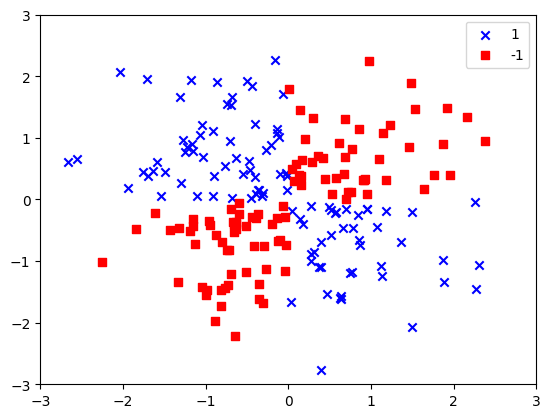

In [39]:
np.random.seed(0)
x_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(x_xor[:, 0] > 0, x_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
# データの散布
plt.scatter(x_xor[y_xor == 1, 0], x_xor[y_xor == 1, 1], c='b', marker='x', label='1')
plt.scatter(x_xor[y_xor == -1, 0], x_xor[y_xor == -1, 1], c='r', marker='s', label='-1')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best') # 右上に凡例を出力
plt.show()

##### ホールド・アウト法による学習・テストデータの分割

In [40]:
x_xor_train, x_xor_test, y_xor_train, y_xor_test = train_test_split(x_xor, y_xor, test_size=0.3, random_state=0)

#### アルゴリズム
グリッドサーチのアルゴリズムを生成

##### パラメタのグリッドを作成

In [41]:
param_grid = {
    'C': [0.1, 1.0, 10, 100, 1000, 10000],
    'gamma': [0.001, 0.01, 0.1, 1, 10]}

##### 層化k分割交差検証法の設定

In [42]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

##### アルゴリズムの初期化

In [43]:
gs_svc = GridSearchCV(SVC(), param_grid, cv=kf)

##### 学習

In [44]:
gs_svc.fit(x_xor_train, y_xor_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100, 1000, 10000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]})

##### 評価

###### 結果の出力

In [45]:
# 精度が最も高かった組み合わせ
print("best_params_: ", gs_svc.best_params_)
# その際のスコア
print("best_score_: ", gs_svc.best_score_)
# データセットの正答率
gs_svc.score(x_xor_test, y_xor_test)

best_params_:  {'C': 1000, 'gamma': 0.1}
best_score_:  0.9642857142857142


0.9666666666666667

###### 決定境界の出力

<Axes: >

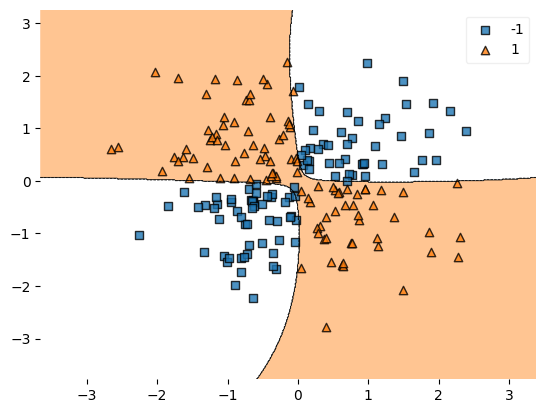

In [46]:
plot_decision_regions(x_xor, y_xor.flatten(), gs_svc)

### 特徴量の選択とエンジニアリング

#### 特徴量の選択
- [相関行列・ヒートマップで特徴量を選択（回帰）](ScikitLearnTraining0.ipynb)
- [散布図行列で特徴量を選択（回帰・分類）](ScikitLearnTraining0.ipynb)
- アルゴリズムで評価
  - 回帰：[重回帰でデータの標準化を施してあれば、偏回帰係数を参考にできる](ScikitLearnTraining1.ipynb)
  - 分類：[RandomForestClassifierの機能で各特徴量の重要度を出力できる](ScikitLearnTraining3.ipynb)

#### 特徴量エンジニアリング

##### [主成分分析後の分類など](ScikitLearnTraining4.ipynb)

##### [高度な特徴量エンジニアリング（Kaggleコンペ）](ScikitLearnTraining6.ipynb)